<a href="https://colab.research.google.com/github/Nhathuyy/DistilBERT-Twitter-Urgent/blob/main/Ensemble_%26_BERT_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install typing-extensions==4.6.1

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.2.0 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.6.0 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
  Using cached typing_extensions-4.6.1-py3-none-any.whl (31 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.6.1 which is incompatible.


In [ ]:

import tensorflow as tf
import keras_core as keras
import keras_nlp

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.13.0
KerasNLP version: 0.6.1


In [ ]:
df_train = pd.read_csv("https://raw.githubusercontent.com/Nhathuyy/Colab/main/train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/Nhathuyy/Colab/main/test.csv")
df_sample_submission = pd.read_csv("https://raw.githubusercontent.com/Nhathuyy/Colab/main/sample_submission.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
print('sample_submission Set Shape = {}'.format(df_sample_submission.shape))
print('sample_submission Set Memory Usage = {:.2f} MB'.format(df_sample_submission.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB
sample_submission Set Shape = (3263, 2)
sample_submission Set Memory Usage = 0.05 MB


In [ ]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# Chuyển về chữ thường
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: x.lower())

# Tokenization
df_train['tokens'] = df_train['text'].apply(word_tokenize)
df_test['tokens'] = df_test['text'].apply(word_tokenize)

# Loại bỏ stopwords
stop_words = set(stopwords.words('english'))
df_train['tokens'] = df_train['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df_test['tokens'] = df_test['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# In ra kết quả
print(df_train.head())
print(df_test.head())





                              text  target                        tokens
0  this is a positive news article       1     [positive, news, article]
1         another positive article       1  [another, positive, article]
2              negative news story       0       [negative, news, story]
3                  positive report       1            [positive, report]
4                  negative report       0            [negative, report]
   id keyword location                                               text  \
0   0     NaN      NaN                        happened terrible car crash   
1   2     NaN      NaN  heard earthquake different cities stay safe ev...   
2   3     NaN      NaN  forest fire spot pond geese fleeing across str...   
3   9     NaN      NaN              apocalypse lighting spokane wildfires   
4  11     NaN      NaN             typhoon soudelor kills 28 china taiwan   

   length                                             tokens  
0      34                   [happene

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

df_train['tokens'] = df_train['tokens'].apply(remove_stopwords)
df_test['tokens'] = df_test['tokens'].apply(remove_stopwords)


In [ ]:
!pip install nltk


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df_train['tokens'] = df_train['tokens'].apply(lemmatize_tokens)
df_test['tokens'] = df_test['tokens'].apply(lemmatize_tokens)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Chọn số lượng tối đa 1000 từ
tfidf_train = tfidf_vectorizer.fit_transform(df_train['tokens'].apply(' '.join))
tfidf_test = tfidf_vectorizer.transform(df_test['tokens'].apply(' '.join))


In [ ]:
# Tạo ma trận TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['text'])


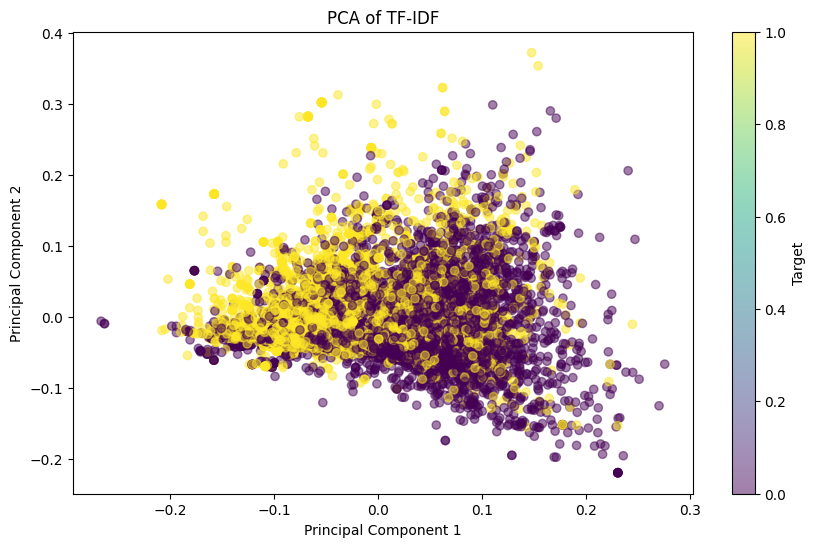

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA


# Tạo ma trận TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['text'])


# Sắp xếp theo tần suất
keywords = tfidf_vectorizer.get_feature_names_out()

# Sử dụng PCA để giảm chiều dữ liệu xuống 2D
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())



# Tạo biểu đồ scatter plot sau khi giảm chiều dữ liệu bằng PCA
plt.figure(figsize=(10, 6))
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=df_train['target'], cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of TF-IDF')
plt.colorbar(label='Target')
plt.show()


Accuracy: 0.8017071569271176
Precision: 0.8160291438979964
Recall: 0.6902927580893683
F1 Score: 0.7479131886477463


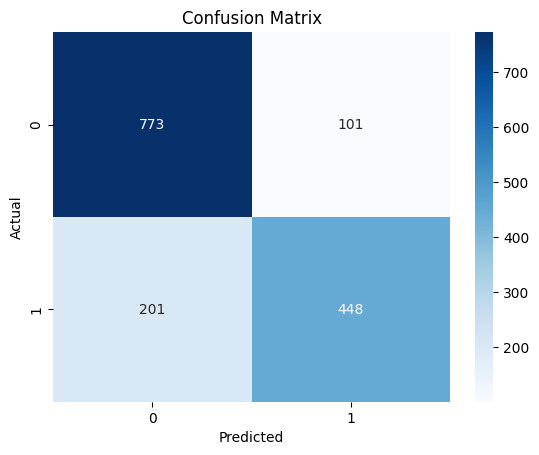

In [ ]:
# Tiếp tục làm sạch dữ liệu
df_train['text_cleaned'] = df_train['text'].apply(clean_text)

# Tách dữ liệu thành tập train và tập validation
from sklearn.model_selection import train_test_split

X = df_train['text_cleaned']
y = df_train['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Sử dụng TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Chỉ lấy 5000 từ có tần suất cao nhất
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

# Xây dựng mô hình Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Đánh giá mô hình trên tập validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_valid_tfidf)
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Trực quan hóa kết quả dự đoán
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_valid, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Accuracy (SVM): 0.7964543663821405
Precision (SVM): 0.8010657193605684
Recall (SVM): 0.6949152542372882
F1 Score (SVM): 0.7442244224422443


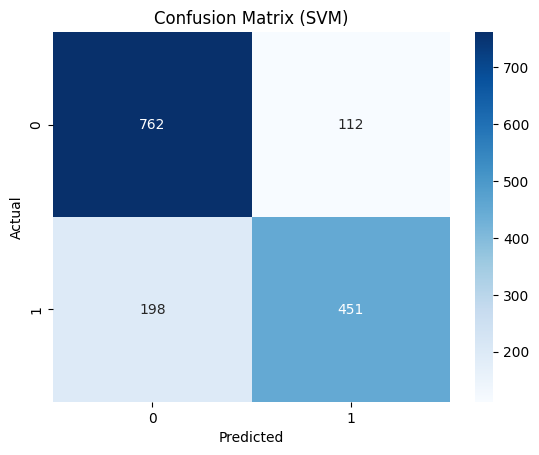

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       874
           1       0.80      0.69      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Xây dựng mô hình SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Dự đoán trên tập validation
y_pred_svm = svm_model.predict(X_valid_tfidf)

# Đánh giá mô hình
accuracy_svm = accuracy_score(y_valid, y_pred_svm)
precision_svm = precision_score(y_valid, y_pred_svm)
recall_svm = recall_score(y_valid, y_pred_svm)
f1_svm = f1_score(y_valid, y_pred_svm)

print("Accuracy (SVM):", accuracy_svm)
print("Precision (SVM):", precision_svm)
print("Recall (SVM):", recall_svm)
print("F1 Score (SVM):", f1_svm)

# Trực quan hóa kết quả dự đoán bằng confusion matrix
conf_matrix_svm = confusion_matrix(y_valid, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()

# In classification report
class_report_svm = classification_report(y_valid, y_pred_svm)
print(class_report_svm)


Accuracy (Naive Bayes): 0.8049901510177282
Precision (Naive Bayes): 0.8283582089552238
Recall (Naive Bayes): 0.6841294298921418
F1 Score (Naive Bayes): 0.7493670886075948


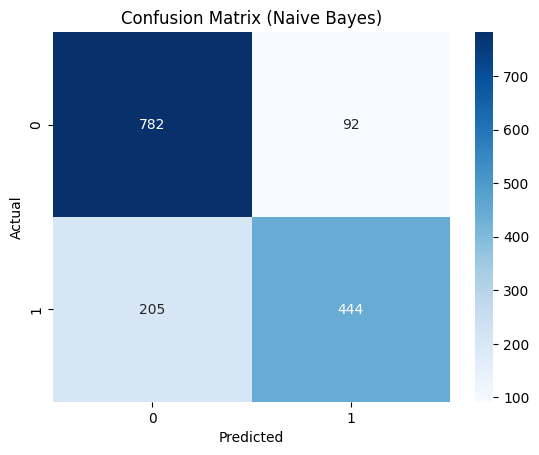

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Xây dựng mô hình Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Dự đoán trên tập validation
y_pred_nb = nb_model.predict(X_valid_tfidf)

# Đánh giá mô hình
accuracy_nb = accuracy_score(y_valid, y_pred_nb)
precision_nb = precision_score(y_valid, y_pred_nb)
recall_nb = recall_score(y_valid, y_pred_nb)
f1_nb = f1_score(y_valid, y_pred_nb)

print("Accuracy (Naive Bayes):", accuracy_nb)
print("Precision (Naive Bayes):", precision_nb)
print("Recall (Naive Bayes):", recall_nb)
print("F1 Score (Naive Bayes):", f1_nb)

# Trực quan hóa kết quả dự đoán bằng confusion matrix
conf_matrix_nb = confusion_matrix(y_valid, y_pred_nb)
sns.heatmap(conf_matrix_nb, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()

# In classification report
class_report_nb = classification_report(y_valid, y_pred_nb)
print(class_report_nb)


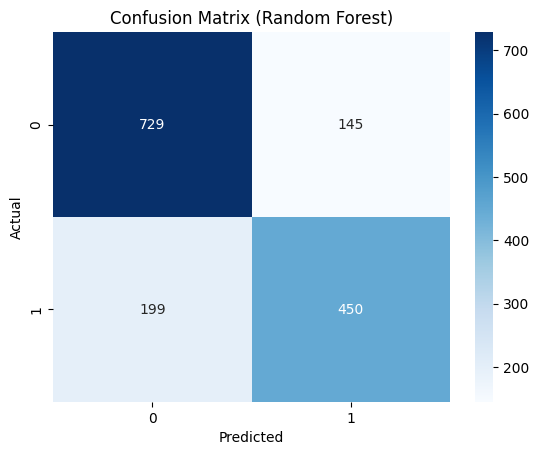

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       874
           1       0.76      0.69      0.72       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.77      0.77      0.77      1523



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Xây dựng mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Dự đoán trên tập validation
y_pred_rf = rf_model.predict(X_valid_tfidf)

# Đánh giá mô hình
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
precision_rf = precision_score(y_valid, y_pred_rf)
recall_rf = recall_score(y_valid, y_pred_rf)
f1_rf = f1_score(y_valid, y_pred_rf)

# Trực quan hóa kết quả dự đoán bằng confusion matrix
conf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# In classification report
class_report_rf = classification_report(y_valid, y_pred_rf)
print(class_report_rf)


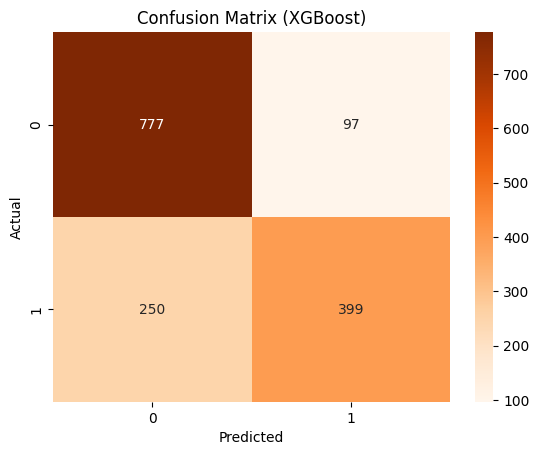

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       874
           1       0.80      0.61      0.70       649

    accuracy                           0.77      1523
   macro avg       0.78      0.75      0.76      1523
weighted avg       0.78      0.77      0.77      1523



In [ ]:
import xgboost as xgb

# Xây dựng mô hình XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_tfidf, y_train)

# Dự đoán trên tập validation
y_pred_xgb = xgb_model.predict(X_valid_tfidf)

# Đánh giá mô hình
accuracy_xgb = accuracy_score(y_valid, y_pred_xgb)
precision_xgb = precision_score(y_valid, y_pred_xgb)
recall_xgb = recall_score(y_valid, y_pred_xgb)
f1_xgb = f1_score(y_valid, y_pred_xgb)

# Trực quan hóa kết quả dự đoán bằng confusion matrix
conf_matrix_xgb = confusion_matrix(y_valid, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, cmap="Oranges", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

# In classification report
class_report_xgb = classification_report(y_valid, y_pred_xgb)
print(class_report_xgb)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Tạo danh sách các giá trị tham số để thử nghiệm
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Xây dựng mô hình XGBoost
xgb_model = xgb.XGBClassifier()

# Sử dụng GridSearchCV để tìm tham số tốt nhất
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_tfidf, y_train)

# In ra tham số tốt nhất
print("Best parameters:", grid_search.best_params_)

# Dự đoán trên tập validation với mô hình tốt nhất
best_xgb_model = grid_search.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_valid_tfidf)

# Đánh giá mô hình tốt nhất
accuracy_best_xgb = accuracy_score(y_valid, y_pred_best_xgb)
precision_best_xgb = precision_score(y_valid, y_pred_best_xgb)
recall_best_xgb = recall_score(y_valid, y_pred_best_xgb)
f1_best_xgb = f1_score(y_valid, y_pred_best_xgb)

# In classification report
class_report_best_xgb = classification_report(y_valid, y_pred_best_xgb)
print(class_report_best_xgb)


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd

# Độ chính xác của các thuật toán
accuracy_scores = [accuracy_svm, accuracy_nb, accuracy_best_xgb]

# Tạo DataFrame
comparison_df = pd.DataFrame({
    'Algorithm': ['SVM', 'Naive Bayes', 'XGBoost'],
    'Accuracy': accuracy_scores
})

# Sắp xếp theo độ chính xác giảm dần
comparison_df = comparison_df.sort_values(by='Accuracy', ascending=False)

# In bảng so sánh
print(comparison_df)


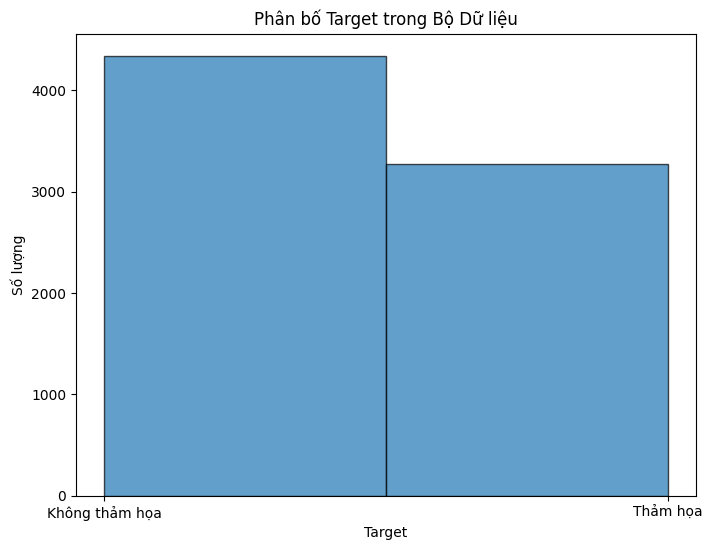

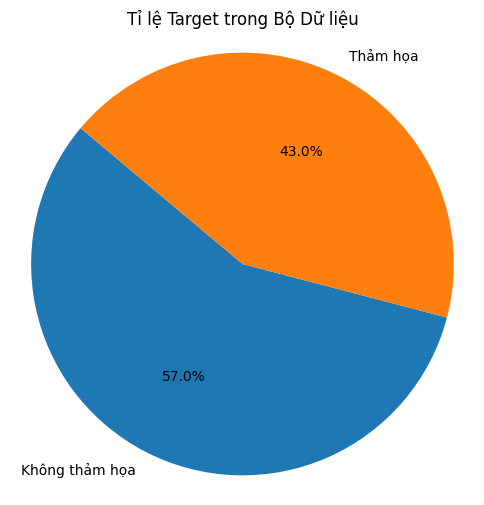

In [ ]:


# Trực quan hoá bằng biểu đồ histogram
plt.figure(figsize=(8, 6))
plt.hist(df_train['target'], bins=2, edgecolor='black', alpha=0.7)
plt.xlabel('Target')
plt.ylabel('Số lượng')
plt.title('Phân bố Target trong Bộ Dữ liệu')
plt.xticks([0, 1], ['Không thảm họa', 'Thảm họa'])
plt.show()

# Trực quan hoá bằng biểu đồ tròn
target_counts = df_train['target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=['Không thảm họa', 'Thảm họa'], autopct='%1.1f%%', startangle=140)
plt.title('Tỉ lệ Target trong Bộ Dữ liệu')
plt.axis('equal')
plt.show()


In [ ]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


# Function to clean text and remove stopwords
def clean_text(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)
    cleaned_text = re.sub(r'@\w+', '', cleaned_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = cleaned_text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

# Clean text in 'text' column of both train and test datasets
df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

# Display the cleaned data
df_train.head()
df_test.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,length
0,0,NaN,NaN,happened terrible car crash,34
1,2,NaN,NaN,Heard earthquake different cities stay safe ev...,64
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...,96
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires,40
4,11,NaN,NaN,Typhoon Soudelor kills 28 China Taiwan,45


In [ ]:
!pip install wordcloud


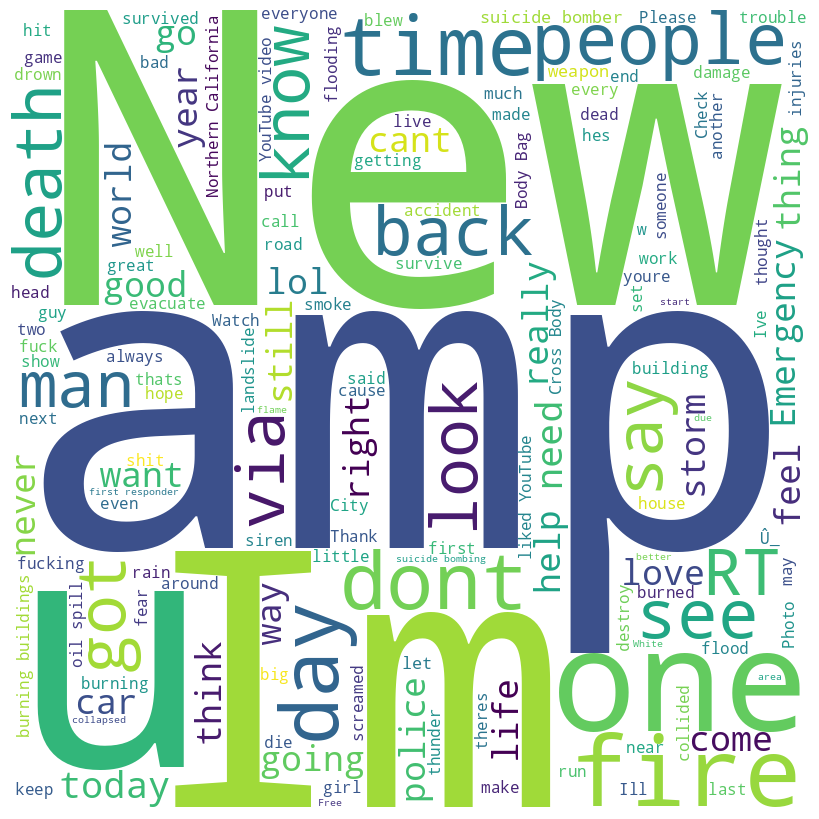

In [ ]:

from wordcloud import WordCloud




# Combine text from both train and test datasets
combined_text = ' '.join(df_train['text']) + ' ' + ' '.join(df_test['text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      max_words=150,
                      colormap='viridis').generate(combined_text)

# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


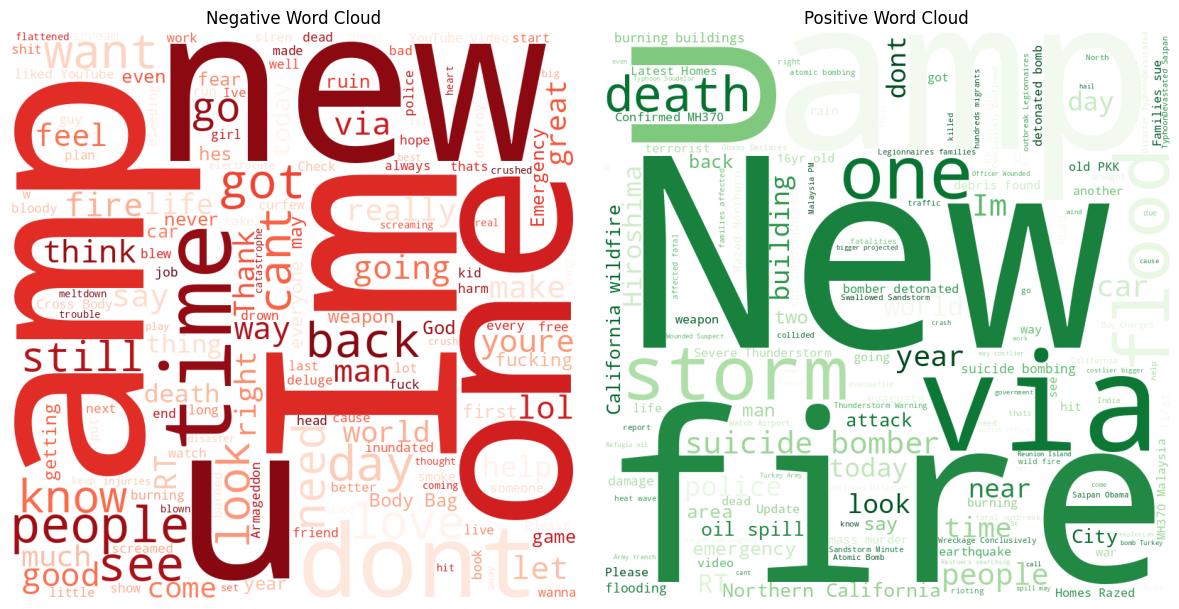

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# Separate positive and negative samples
negative_text = ' '.join(df_train[df_train['target'] == 0]['text'])
positive_text = ' '.join(df_train[df_train['target'] == 1]['text'])

# Create Word Cloud for Negative samples
negative_wordcloud = WordCloud(width=800, height=800,
                               background_color='white',
                               max_words=150,
                               colormap='Reds').generate(negative_text)

# Create Word Cloud for Positive samples
positive_wordcloud = WordCloud(width=800, height=800,
                               background_color='white',
                               max_words=150,
                               colormap='Greens').generate(positive_text)

# Plot Word Clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(negative_wordcloud)
plt.title('Negative Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(positive_wordcloud)
plt.title('Positive Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()


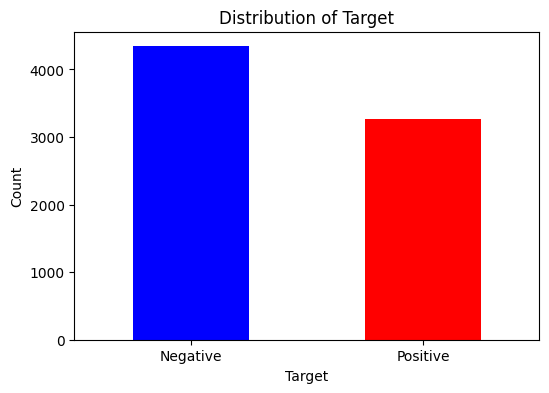

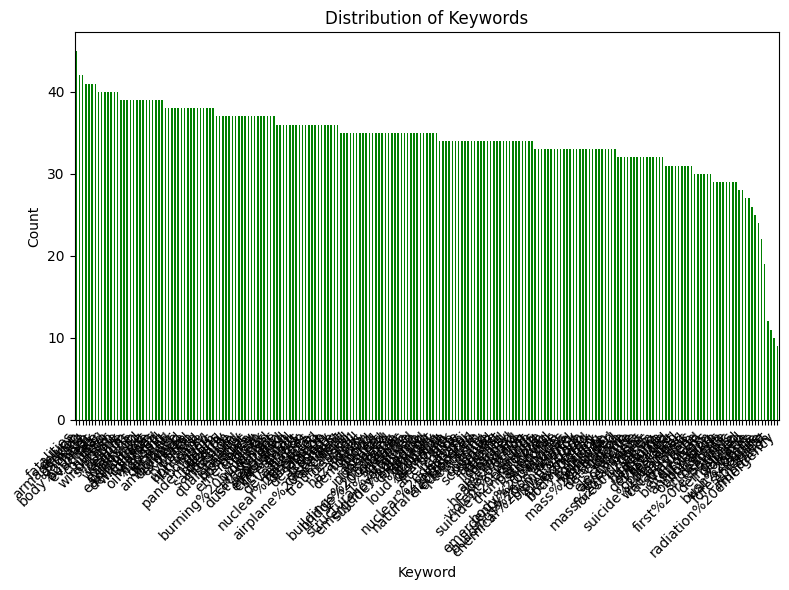

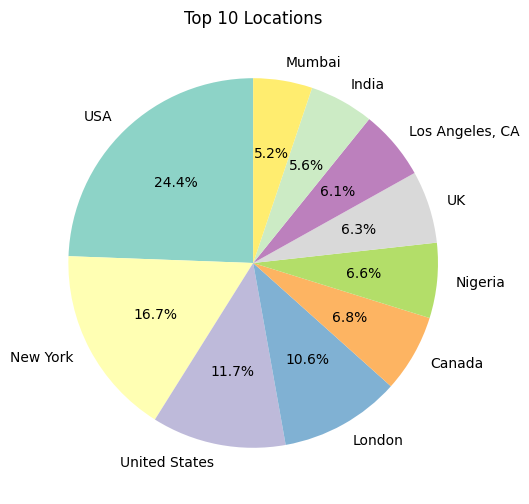

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Trực quan hoá số lượng mẫu theo target
plt.figure(figsize=(6, 4))
df_train['target'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.show()

# Trực quan hoá phân bố từ khóa
plt.figure(figsize=(8, 6))
df_train['keyword'].value_counts().plot(kind='bar', color='green')
plt.title('Distribution of Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




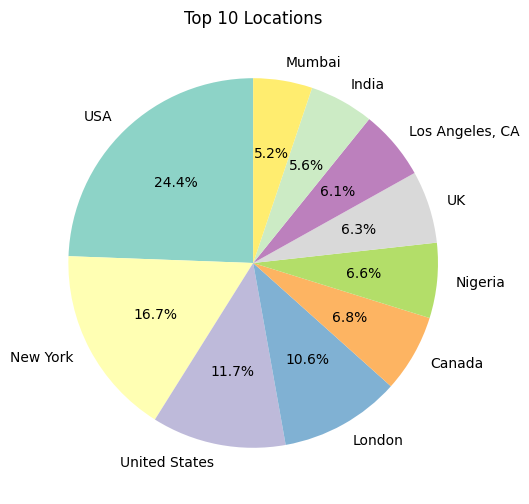

In [ ]:
# Trực quan hoá phân bố theo vị trí
plt.figure(figsize=(8, 6))
df_train['location'].value_counts().head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title('Top 10 Locations')
plt.ylabel('')
plt.show()

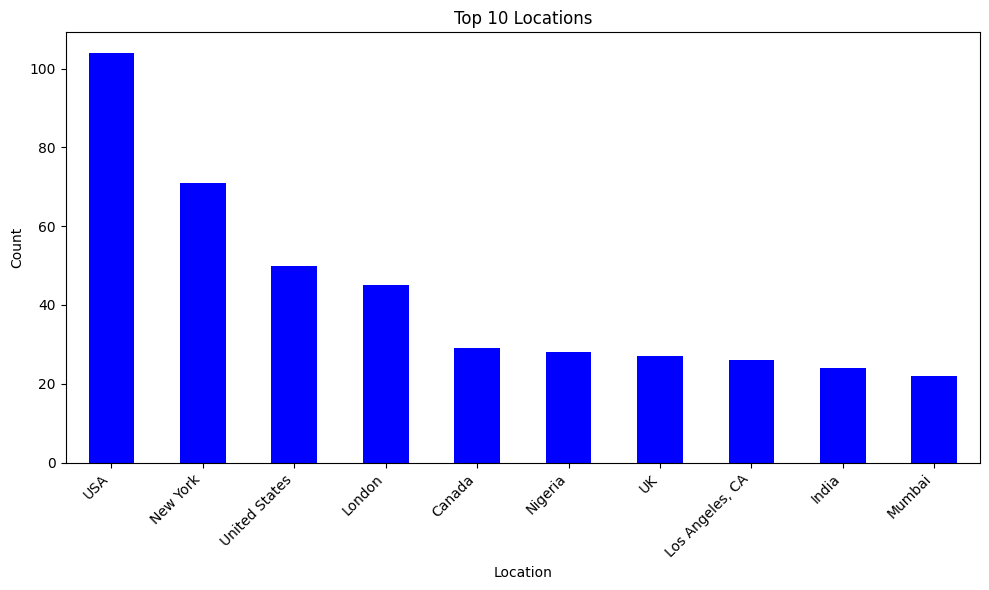

In [ ]:
# Trực quan hoá phân bố theo vị trí
top_locations = df_train['location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar', color='blue')
plt.title('Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Trực quan hoá location ít nhất
bottom_locations = df_train['location'].value_counts().tail(10)

plt.figure(figsize=(10, 6))
bottom_locations.plot(kind='bar', color='green')
plt.title('Top 10 Least Common Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

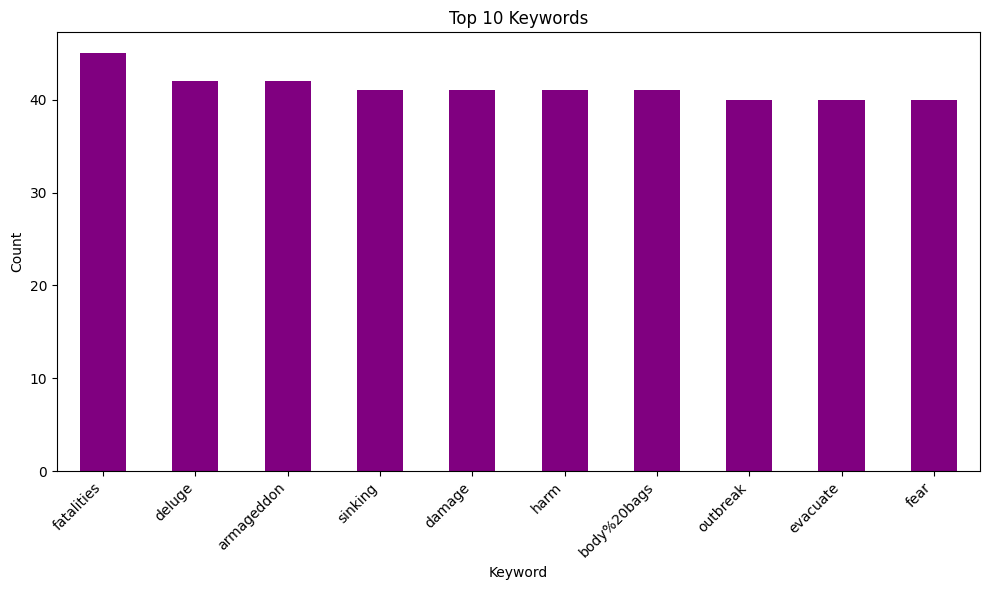

In [ ]:
# Trực quan hoá top 10 từ khóa phổ biến nhất
top_keywords = df_train['keyword'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_keywords.plot(kind='bar', color='purple')
plt.title('Top 10 Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

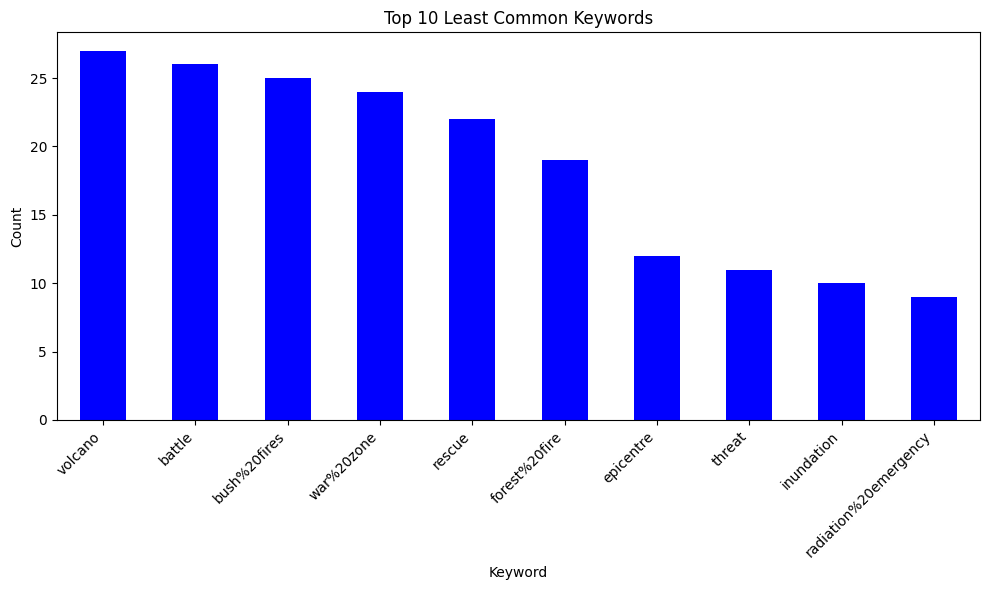

In [ ]:


# Trực quan hoá top 10 keyword ít có nhất
bottom_keywords = df_train['keyword'].value_counts().tail(10)

plt.figure(figsize=(10, 6))
bottom_keywords.plot(kind='bar', color='blue')
plt.title('Top 10 Least Common Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

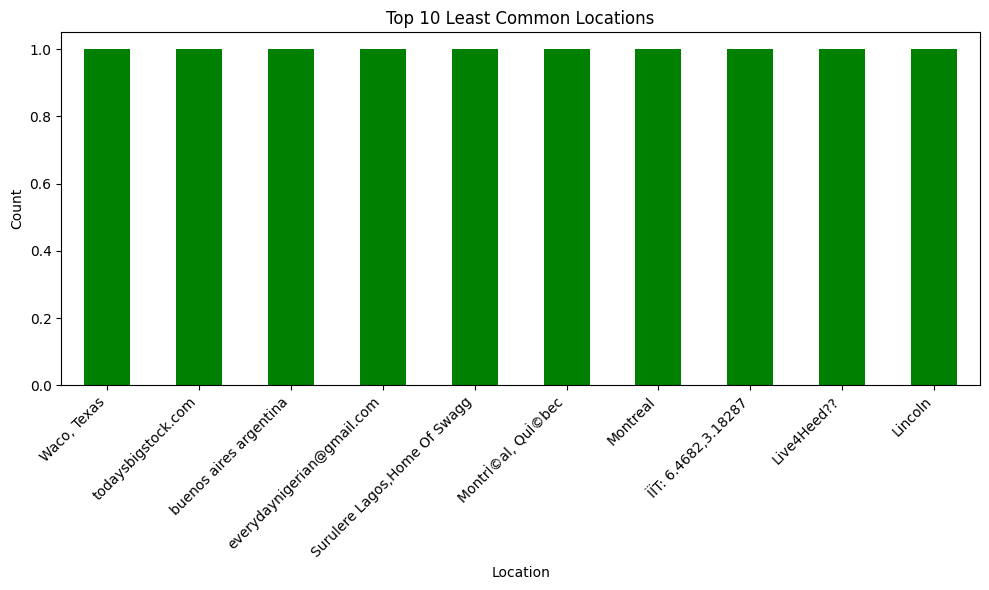

In [ ]:
# Trực quan hoá location ít nhất
bottom_locations = df_train['location'].value_counts().tail(10)

plt.figure(figsize=(10, 6))
bottom_locations.plot(kind='bar', color='green')
plt.title('Top 10 Least Common Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

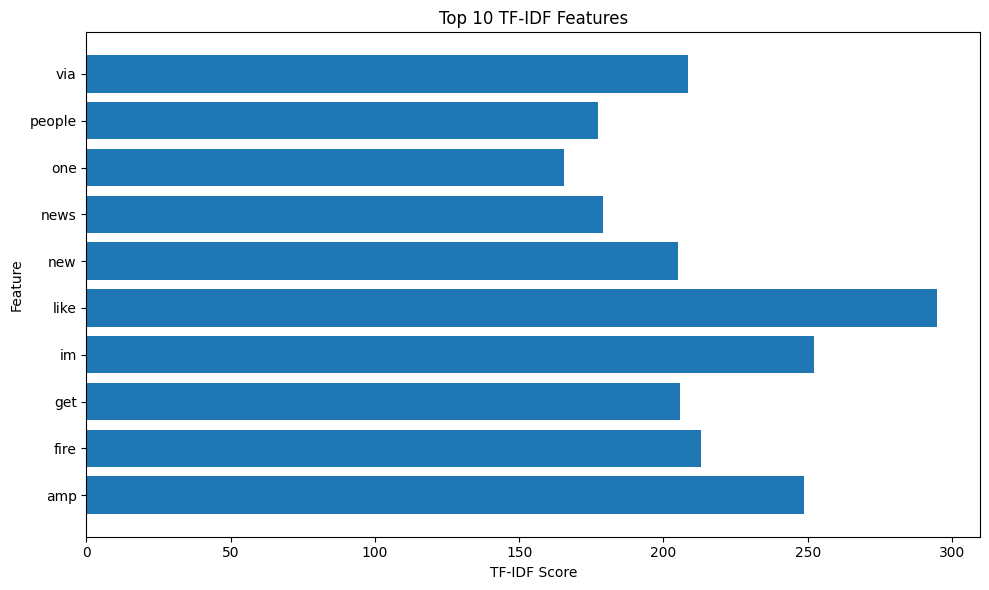

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Sử dụng TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10)  # Chỉ lấy 10 đặc trưng phổ biến
tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['text'])

# Trực quan hoá đặc trưng TF-IDF
features = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1  # Tính tổng điểm TF-IDF cho mỗi đặc trưng

plt.figure(figsize=(10, 6))
plt.barh(features, scores)
plt.title('Top 10 TF-IDF Features')
plt.xlabel('TF-IDF Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 5
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │           0 │ distil_bert_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 7739s 40s/step - accuracy: 0.7129 - loss: 0.5664 - val_accuracy: 0.8365 - val_loss: 0.3956
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 7485s 39s/step - accuracy: 0.8407 - loss: 0.3791 - val_accuracy: 0.8450 - val_loss: 0.3853


In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 1905s 10s/step


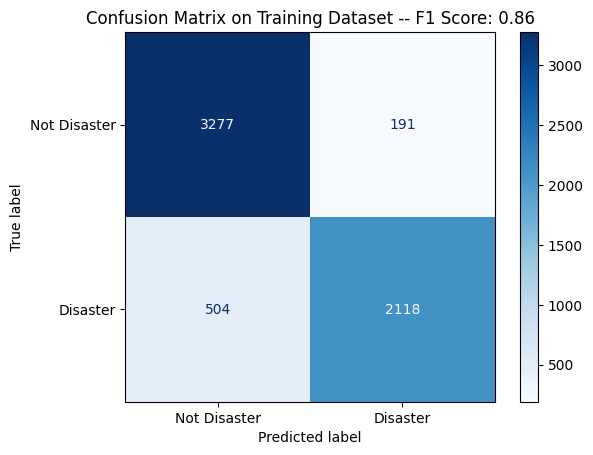

In [ ]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 475s 10s/step


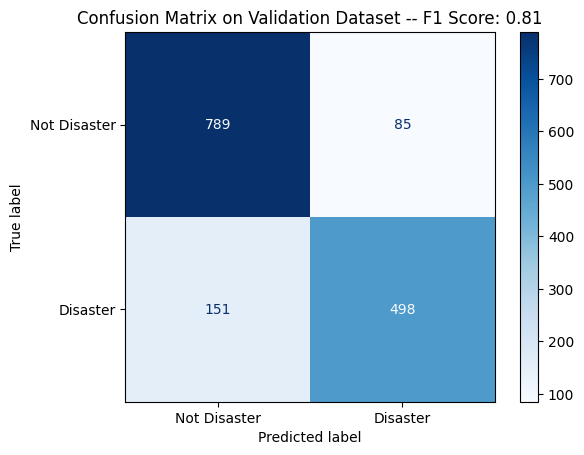

In [ ]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [ ]:

df_sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
df_sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

In [ ]:
df_sample_submission.to_csv("submission.csv", index=False)

In [ ]:
import pandas as pd

# Độ chính xác của các thuật toán
accuracy_scores = [accuracy_svm, accuracy_nb, accuracy_best_xgb]

# Tạo DataFrame
comparison_df = pd.DataFrame({
    'Algorithm': ['SVM', 'Naive Bayes', 'XGBoost'],
    'Accuracy': accuracy_scores
})

# Sắp xếp theo độ chính xác giảm dần
comparison_df = comparison_df.sort_values(by='Accuracy', ascending=False)

# In bảng so sánh
print(comparison_df)
